# <span style="color:indianred">Stock Market Crash Prediction using Topological Analysis<span>
<hr>

## 1. Description and Data pre-processing
### 1.1 Introduction
- A financial crash often manifests after a period of heightened variance in market indicators and increased cross-correlation among various assets. We employ persistent homology on segments of a 4-dimensional time series encompassing key indices such as the Russell2000, S&P 500, DIJA, NASDAQ . This analytical framework yields a vector whose norm serves as a indicator of an impending crash.
The application of persistent homology allows us to identify topological features that persist across various resolutions. This approach is particularly good for capturing long-term trends and patterns, making it a powerful tool for identifying critical shifts in market conditions.


### 1.2 Data Exploration

In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
import gudhi.representations
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def reverse_dataframe(df : pd.DataFrame):
    new_df = df.copy()[::-1]
    new_df.index = range(0, len(df))
    return new_df

In [3]:
df_dowjones = pd.read_csv('resources/dowjones.csv')
df_nasdaq = pd.read_csv('resources/nasdaq.csv')
df_russel2000 = pd.read_csv('resources/russel2000.csv')
df_sp500 = pd.read_csv('resources/sp500.csv')

df_dowjones = reverse_dataframe(df_dowjones)
df_nasdaq = reverse_dataframe(df_nasdaq)
df_russel2000 = reverse_dataframe(df_russel2000)
df_sp500 = reverse_dataframe(df_sp500)

In [4]:
df_dowjones.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1987-12-23,1990.219971,2019.560059,1977.619995,2005.640015,22830000,2005.640015
1,1987-12-24,2003.810059,2013.099976,1985.739990,1999.670044,8080000,1999.670044
2,1987-12-28,1955.569946,1966.180054,1921.920044,1942.969971,13870000,1942.969971
3,1987-12-29,1942.810059,1951.760010,1918.099976,1926.890015,9940000,1926.890015
4,1987-12-30,1935.339966,1966.180054,1925.729980,1950.099976,15120000,1950.099976


In [5]:
df_nasdaq.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1987-12-23,329.100006,331.600006,328.299988,331.500000,164080000,331.500000
1,1987-12-24,332.200012,333.200012,331.299988,333.200012,82010000,333.200012
2,1987-12-28,326.500000,326.500000,324.500000,325.600006,115520000,325.600006
3,1987-12-29,325.100006,325.700012,324.100006,325.500000,120080000,325.500000
4,1987-12-30,328.399994,329.799988,328.399994,329.700012,152920000,329.700012


In [6]:
df_russel2000.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1987-12-23,119.309998,120.820000,119.309998,120.800003,2031100,120.800003
1,1987-12-24,120.790001,121.589996,120.790001,121.589996,1088000,121.589996
2,1987-12-28,121.589996,121.589996,118.680000,119.000000,1312200,119.000000
3,1987-12-29,118.989998,118.989998,118.019997,118.300003,1115800,118.300003
4,1987-12-30,118.309998,119.500000,118.300003,119.500000,1492300,119.500000


In [7]:
df_sp500.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1987-12-23,249.960007,253.350006,249.949997,253.160004,203110000,253.160004
1,1987-12-24,253.130005,253.160004,251.679993,252.029999,108800000,252.029999
2,1987-12-28,252.009995,252.020004,244.190002,245.570007,131220000,245.570007
3,1987-12-29,245.580002,245.880005,244.279999,244.589996,111580000,244.589996
4,1987-12-30,244.630005,248.059998,244.589996,247.860001,149230000,247.860001


In [8]:
def plot_price_data(df_list : list,legend : list, target_column : str, title : str) :
    plt.figure()
    
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
    for df in df_list:
        plt.plot(df["Date"].tolist(), 
                 df[[target_column]],
                 linewidth=.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(legend)
    plt.show()

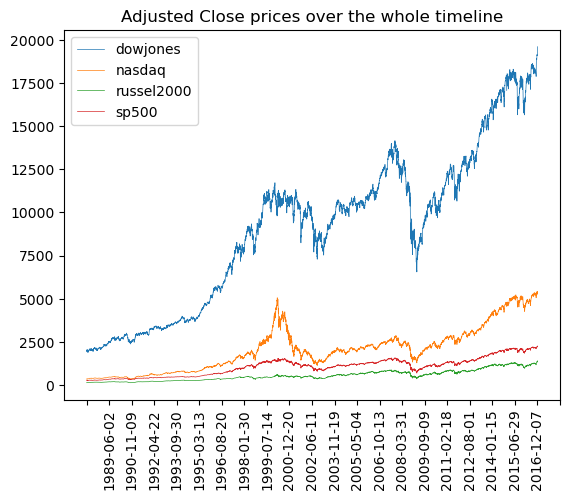

In [9]:
legend = ["dowjones", "nasdaq", "russel2000", "sp500"]
plot_price_data([df_dowjones, df_nasdaq, df_russel2000, df_sp500], legend, "Adj Close", "Adjusted Close prices over the whole timeline")

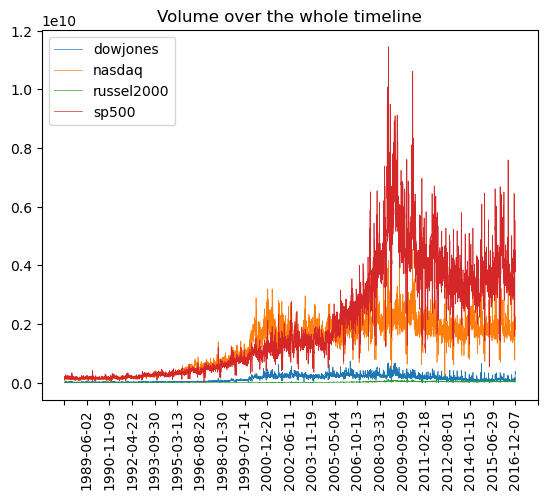

In [10]:
plot_price_data([df_dowjones, df_nasdaq, df_russel2000, df_sp500], legend, "Volume", "Volume over the whole timeline")

### 1.3 Computing log returns

- From the given data of 4 major Stock market indexes, **$(n-1) \times 4$** matrix of log returns is computed, where n is number of daily price datapoints.

- For every given property of price data(Open ,High, Low, Close, Adj Close) log-returns are computed. The main benefit from using relative metrics like returns compared to absolute metrics like prices is **normalization**, that is a requirement for multidimensional statistical analysis setups.

In [11]:
def compute_log_returns(
    df: pd.DataFrame
) -> pd.DataFrame:
    new_df = df.copy()
    price_columns = ["Open", "High", "Low", "Close", "Adj Close"]
    for column in price_columns:
        log_price            = np.log(new_df[column])
        log_price_shifted    = np.log(new_df[column].shift(1))
        new_df[column+"_lr"] = log_price - log_price_shifted
    new_df["Volume Pct Change"] = new_df["Volume"].pct_change()
    return new_df

In [12]:
df_dowjones = compute_log_returns(df_dowjones)
df_nasdaq = compute_log_returns(df_nasdaq)
df_russel2000 = compute_log_returns(df_russel2000)
df_sp500 = compute_log_returns(df_sp500)

In [13]:
df_dowjones.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Open_lr,High_lr,Low_lr,Close_lr,Adj Close_lr,Volume Pct Change
0,1987-12-23,1990.219971,2019.560059,1977.619995,2005.640015,22830000,2005.640015,NaN,NaN,NaN,NaN,NaN,NaN
1,1987-12-24,2003.810059,2013.099976,1985.739990,1999.670044,8080000,1999.670044,0.006805,-0.003204,0.004098,-0.002981,-0.002981,-0.646080
2,1987-12-28,1955.569946,1966.180054,1921.920044,1942.969971,13870000,1942.969971,-0.024369,-0.023583,-0.032667,-0.028764,-0.028764,0.716584
3,1987-12-29,1942.810059,1951.760010,1918.099976,1926.890015,9940000,1926.890015,-0.006546,-0.007361,-0.001990,-0.008310,-0.008310,-0.283345
4,1987-12-30,1935.339966,1966.180054,1925.729980,1950.099976,15120000,1950.099976,-0.003852,0.007361,0.003970,0.011973,0.011973,0.521127


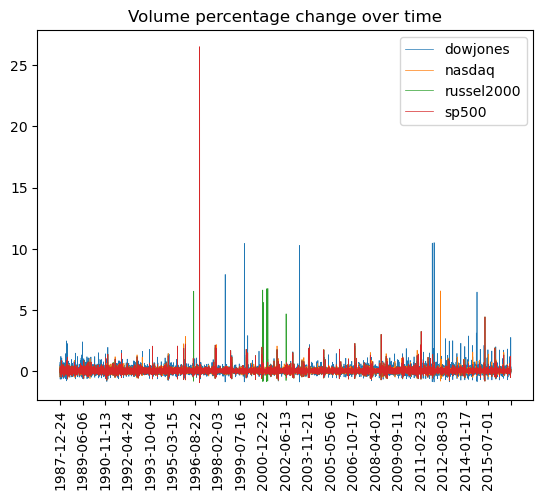

In [14]:
plot_price_data([df_dowjones, df_nasdaq, df_russel2000, df_sp500], legend, "Volume Pct Change", "Volume percentage change over time")

## 2. Computing Persistance diagrams and Persistance landscapes

In [15]:
def compute_persistence_diagram(
    point_cloud:   np.ndarray,
    print_graph:   bool        = False,
    memory_saving: tuple       = (False, 1)
) -> np.ndarray:
    simplex   = gd.RipsComplex(points = point_cloud)
    simplex   = simplex.create_simplex_tree(max_dimension = 2)
    bar_codes = simplex.persistence()
    if memory_saving[0]:
        simplex = simplex.persistence_intervals_in_dimension(memory_saving[1])
        
    if print_graph:
        gd.plot_persistence_diagram(bar_codes)

    return simplex

usetex mode requires dvipng.


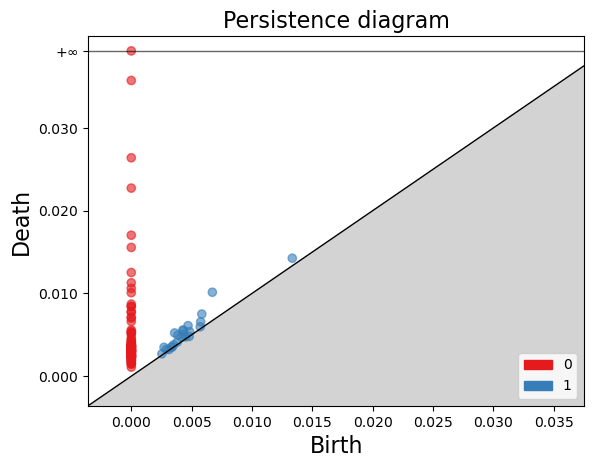

In [16]:
w_window_size = 50
data = np.array([
    df_dowjones["Adj Close_lr"][1:100],
    df_nasdaq["Adj Close_lr"][1:100],
    df_russel2000["Adj Close_lr"][1:100],
    df_sp500["Adj Close_lr"][1:100]]).T
columns = ["dowjones", "nasdaq", "russel2000", "sp500"]
index   = df_dowjones["Date"][1:100]

data = pd.DataFrame(data, columns=columns, index=index)
data = data.values

example_diagram = compute_persistence_diagram(data, True, (True, 1))

In [17]:
def compute_persistence_diagrams(
    data:          pd.DataFrame, 
    w:             int,
    memory_saving: tuple         = (False, 1)
) -> np.ndarray:
    diagrams = []
    for slc in range(data.shape[0]-w):
        point_cloud = data[slc:slc+w]
        diagram     = compute_persistence_diagram(point_cloud, False, memory_saving)
        diagrams.append(diagram)
    return diagrams

In [18]:
def compute_persistence_landscape(
    diagram:            np.ndarray,         # diagram range
    endpoints:          list,               # endpoints
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:

    if endpoints[0] == endpoints[1] == 0:
        return np.zeros((n_landscapes, resolution))

    diagram_range = endpoints
    if not memory_saving:
        diagram = diagram.persistence_intervals_in_dimension(homology_dimension)
    x_range        =  np.linspace(diagram_range[0], 
                                  diagram_range[1],
                                  resolution)
    step           = x_range[1] - x_range[0]
    length_diagram = len(diagram)
    computed_landscapes_at_given_resolution = np.zeros([n_landscapes, resolution])
    computed_y_values = [[] for _ in range(resolution)]

    compute_x_subrange = lambda x: int(np.ceil(x/step))

    for x, y in diagram:
        min_point = x - diagram_range[0]
        mid_point = 0.5*(x+y) - diagram_range[0]
        max_point = y - diagram_range[0]
        minimum_x = compute_x_subrange(min_point)
        middle_x  = compute_x_subrange(mid_point)
        maximum_x = compute_x_subrange(max_point)

        if minimum_x<resolution and maximum_x>0:
            y_value = diagram_range[0] + minimum_x * step - x
            for i in range(minimum_x, middle_x):
                computed_y_values[i].append(y_value)
                y_value += step
            y_value = y - diagram_range[0] - middle_x * step
            for i in range(middle_x, maximum_x):
                computed_y_values[i].append(y_value)
                y_value -= step

    for i in range(resolution):
        computed_y_values[i].sort(reverse=True)
        max_range = min(n_landscapes, len(computed_y_values[i]))
        for j in range(max_range):
            computed_landscapes_at_given_resolution[j,i] = computed_y_values[i][j]
            
    return computed_landscapes_at_given_resolution

In [19]:
def compute_persistence_landscapes(
    diagrams:           np.ndarray,         # diagram D
    homology_dimension: int         = 1,    # k dimensions
    n_landscapes:       int         = 5,    # m landscapes
    resolution:         int         = 1000, # n nodes
    memory_saving:      bool        = False
) -> np.ndarray:
    k = homology_dimension

    def compute_endpoint(d, minmax):
        d = d.persistence_intervals_in_dimension(k)
        if len(d) > 0 and minmax=="min":
            return np.min(d)
        elif len(d) > 0 and minmax=="max":
            return np.max(d)
        return 0
        
    if memory_saving:
        minp = lambda d: np.min(d) if len(d)>0 else 0
        maxp = lambda d: np.max(d) if len(d)>0 else 0
    else:
        def compute_endpoint(d, minmax):
            d = d.persistence_intervals_in_dimension(k)
            if len(d)>0 and minmax=="min":    return np.min(d)
            elif len(d) >0 and minmax=="max": return np.max(d)
            else:                             return 0
        minp = lambda d: compute_endpoint(d, "min")
        maxp = lambda d: compute_endpoint(d, "max")

    landscapes = [
        compute_persistence_landscape(
            diag,                     # diagram D
            [minp(diag), maxp(diag)], # endpoints
            homology_dimension,       # k dimensions
            n_landscapes,             # m landscapes
            resolution,               # n nodes
            memory_saving
        ) for diag in diagrams
    ]
    return landscapes

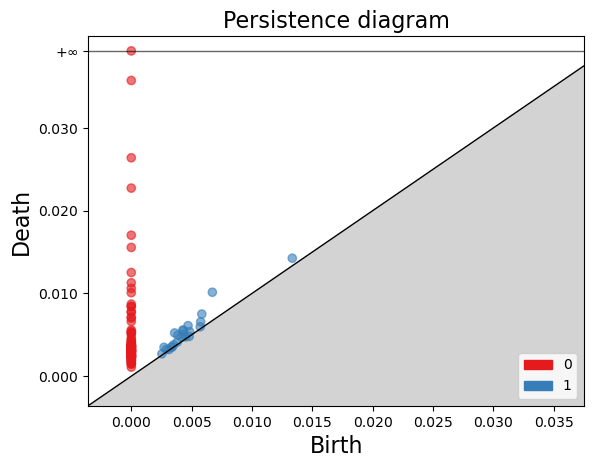

In [30]:
diagram   = compute_persistence_diagram(data, True, (True, 1))
landscape = compute_persistence_landscape(diagram, [0, 100], 1, 2, 100, True)

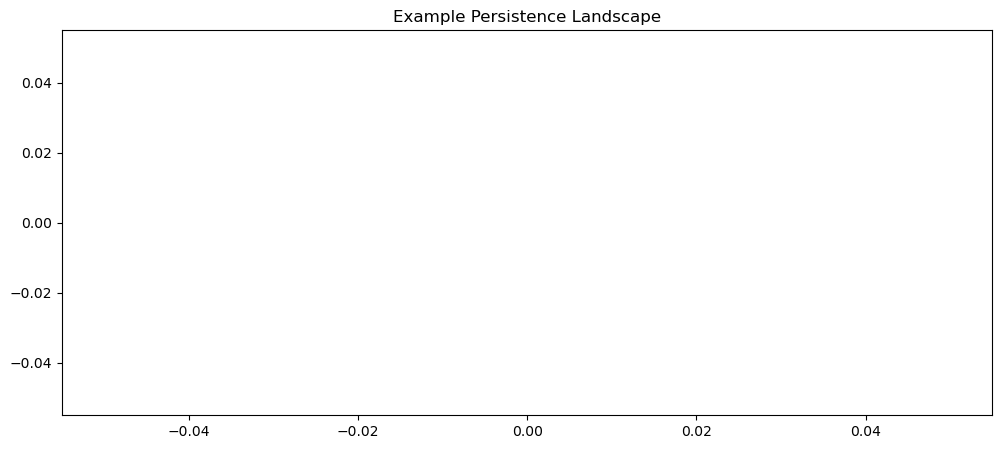

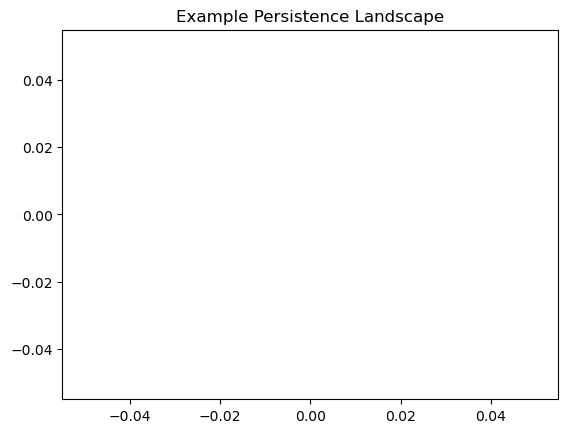

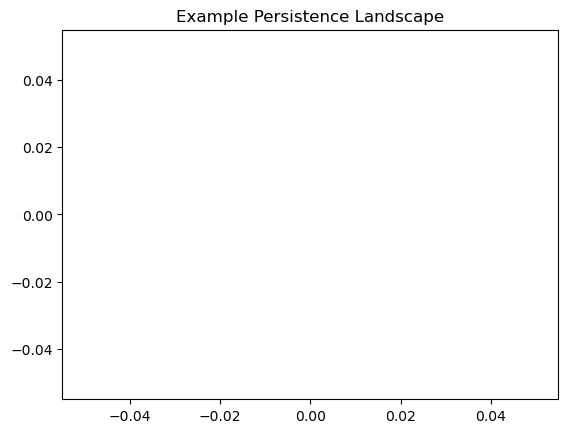

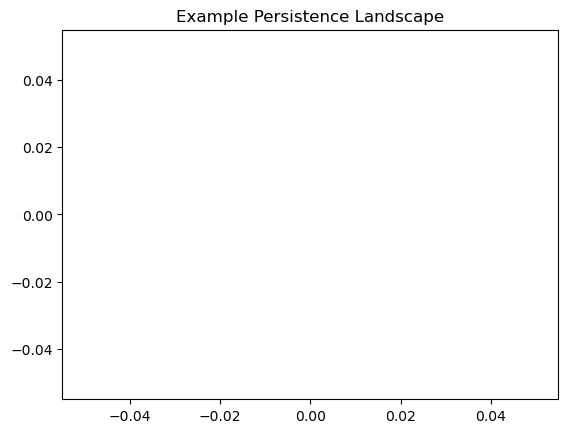

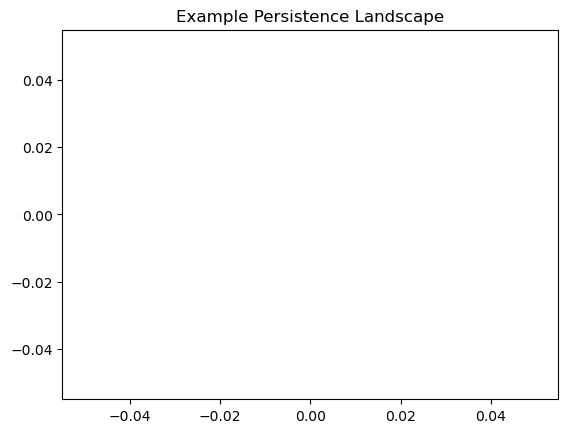

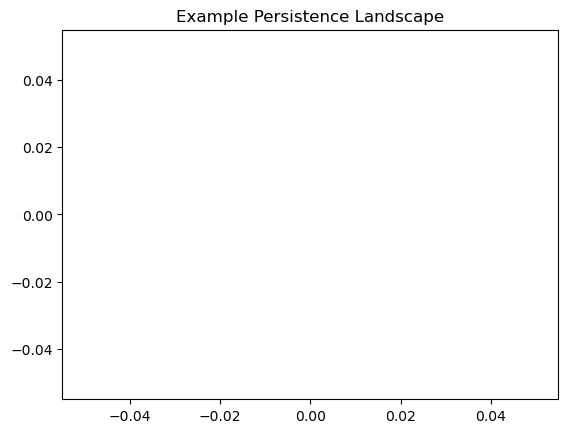

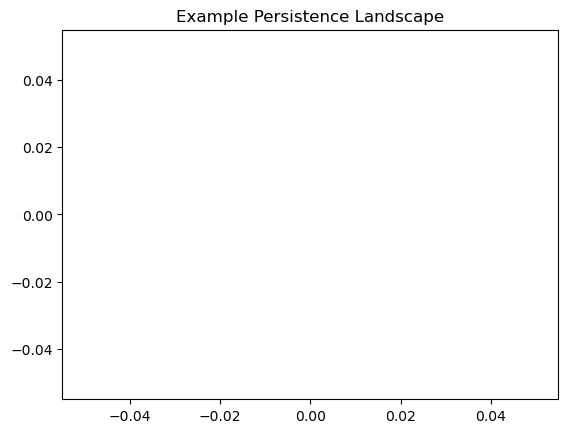

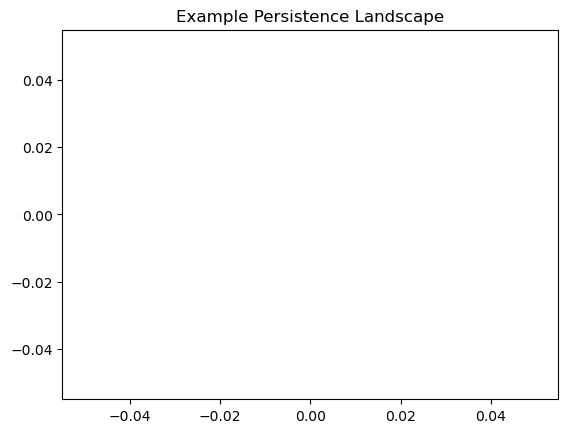

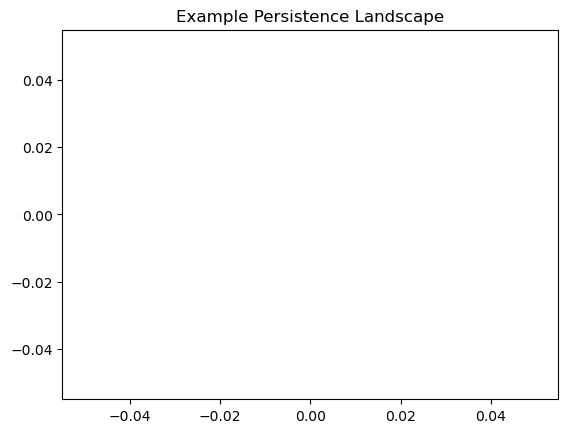

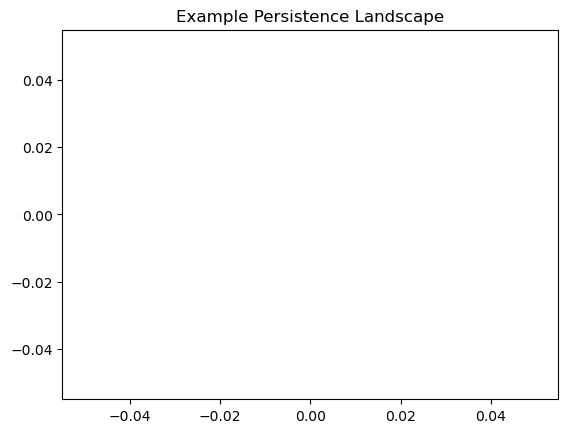

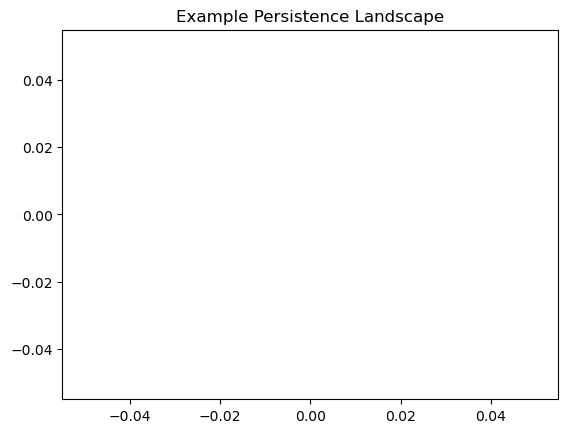

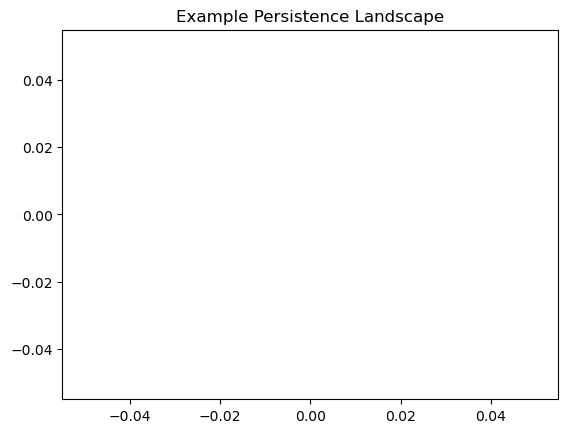

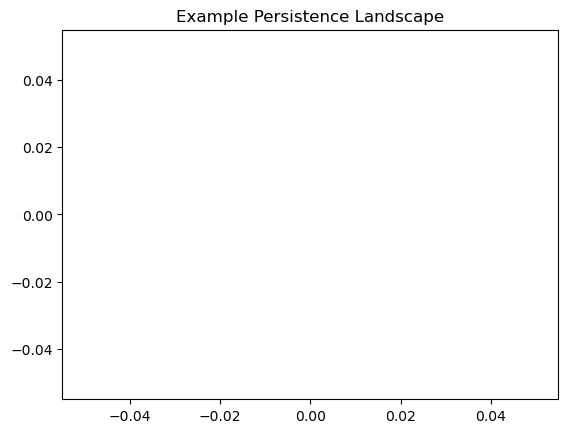

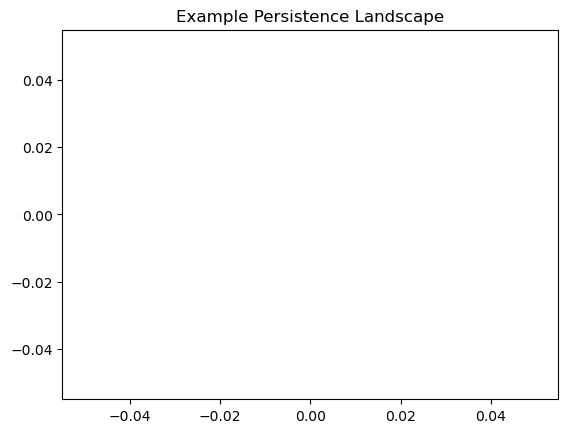

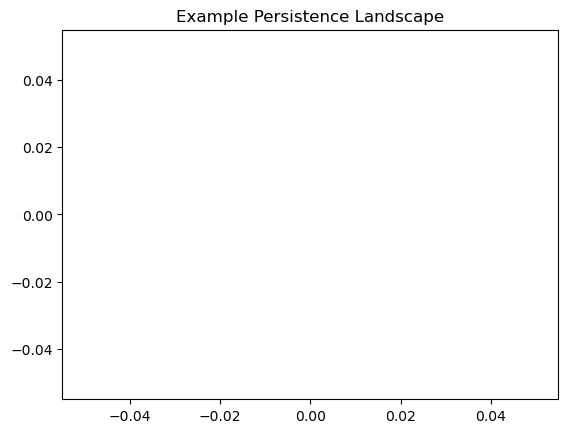

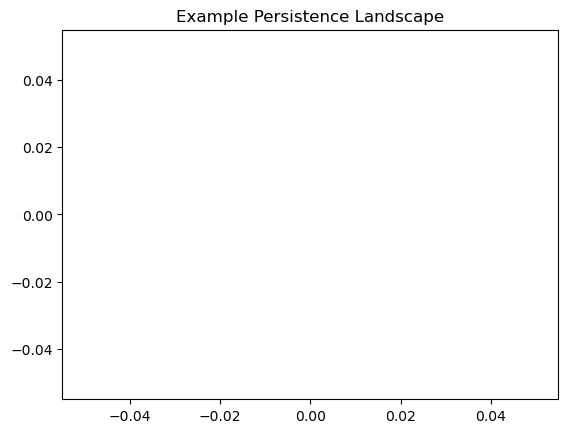

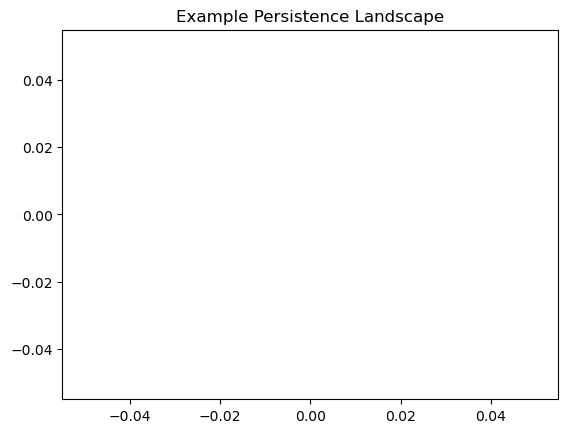

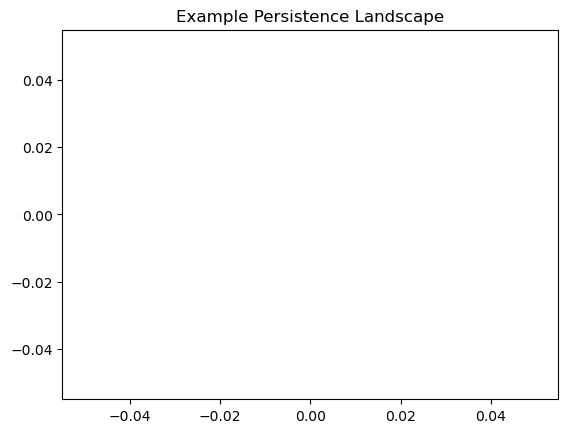

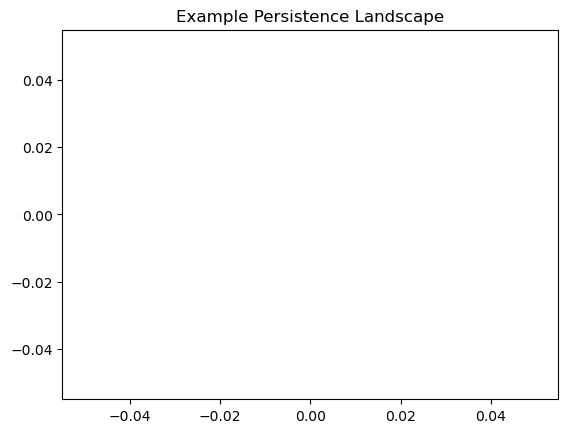

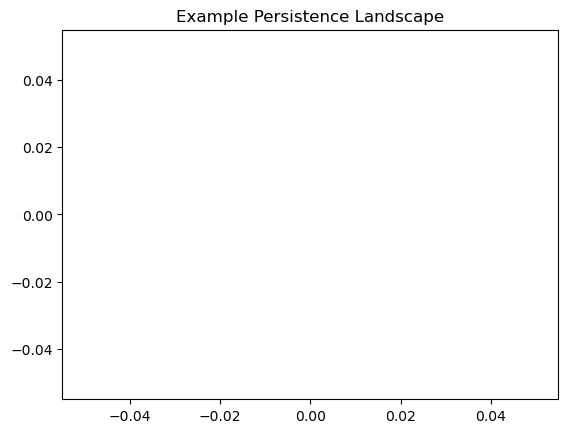

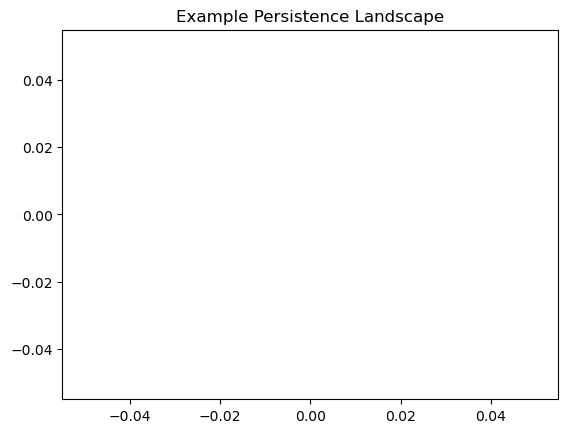

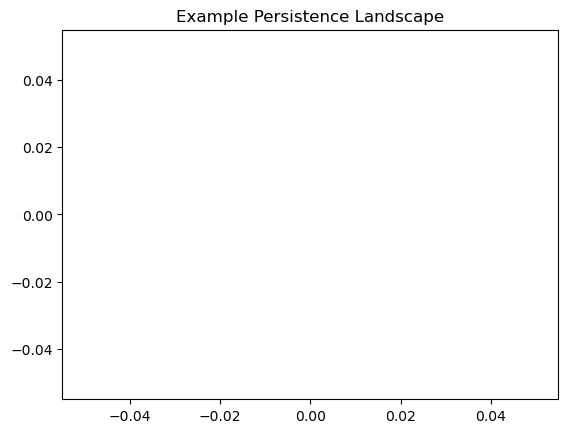

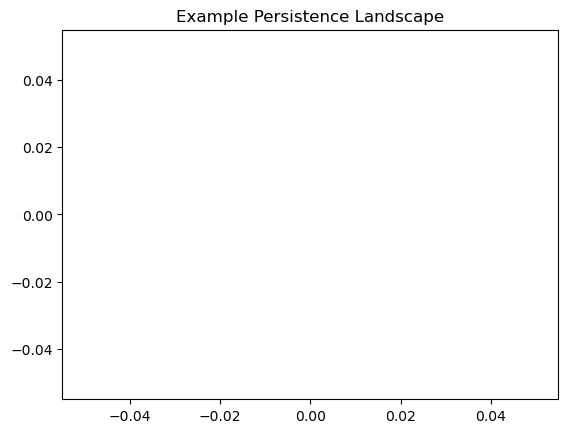

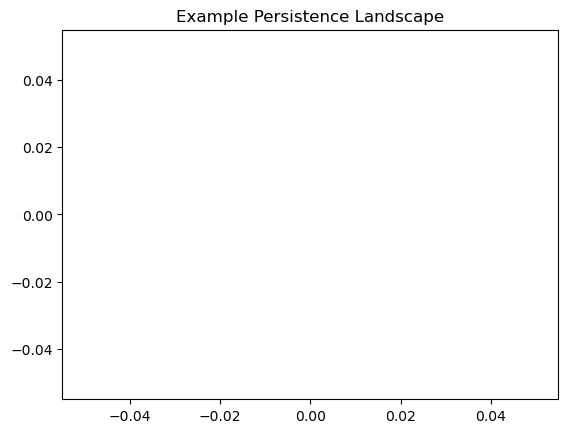

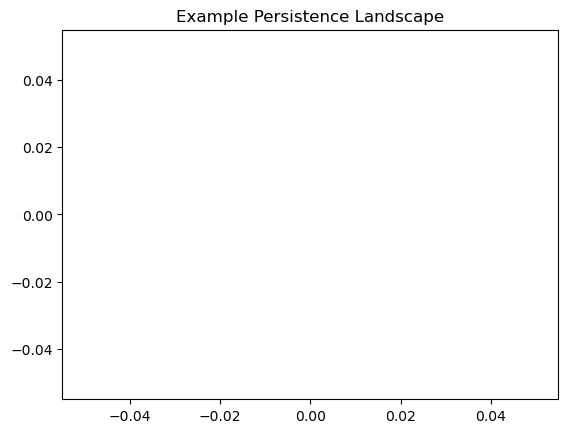

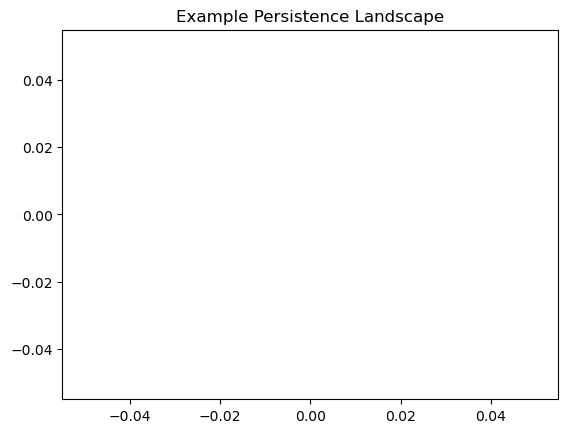

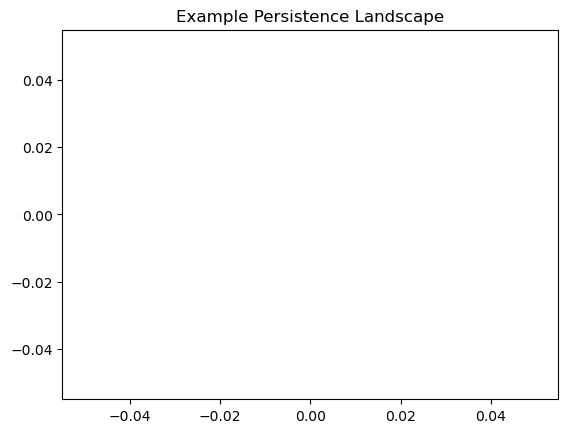

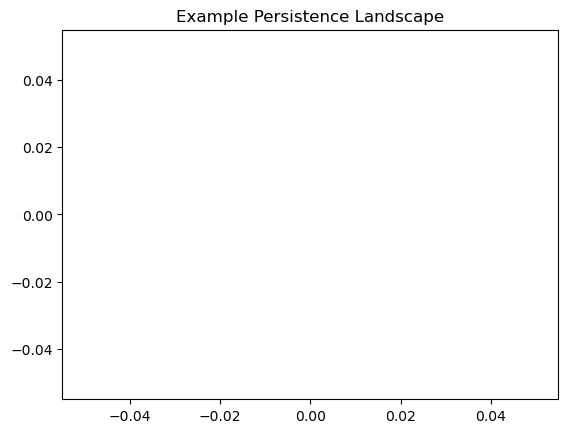

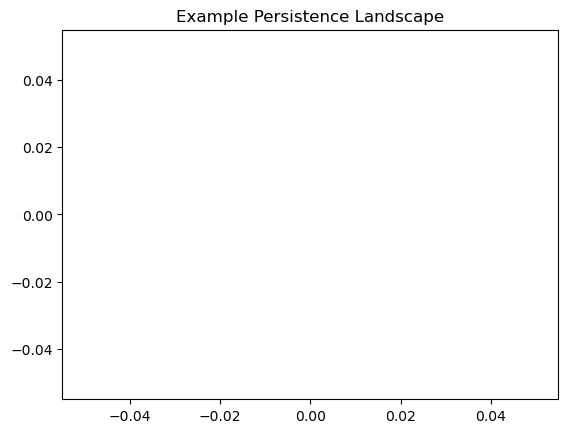

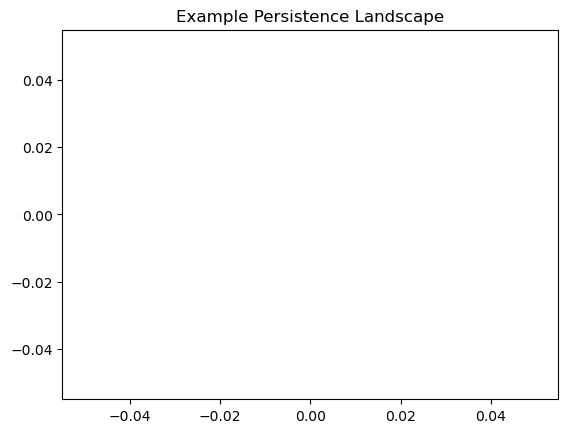

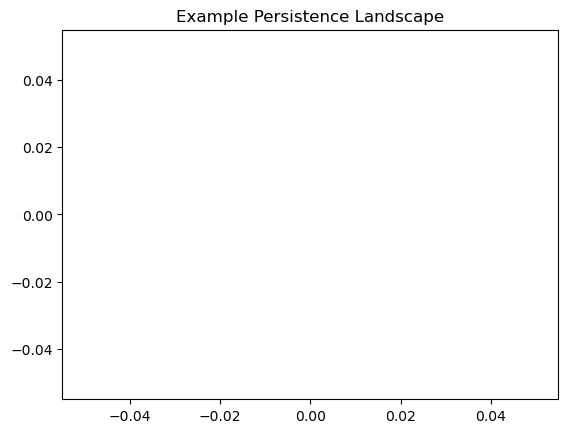

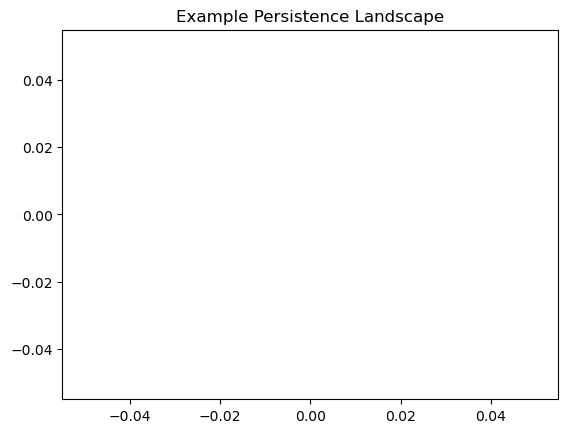

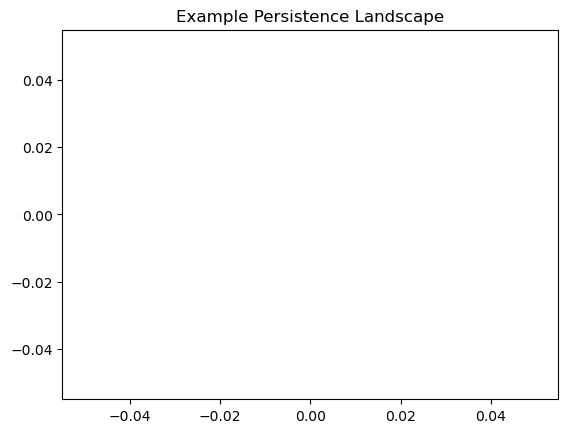

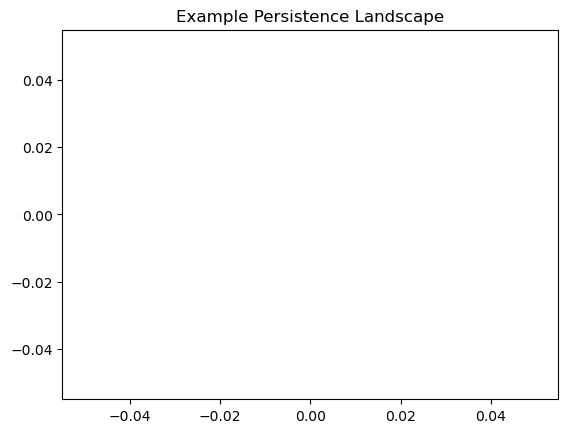

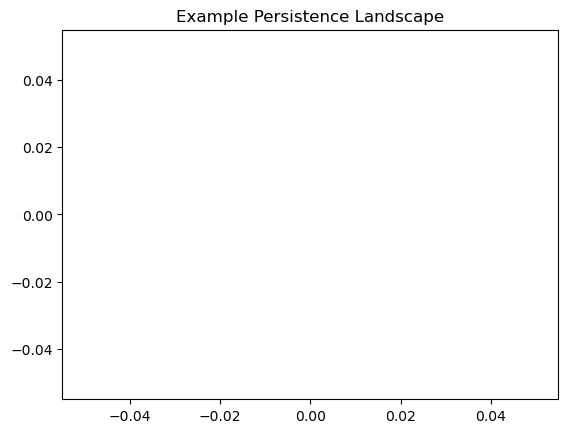

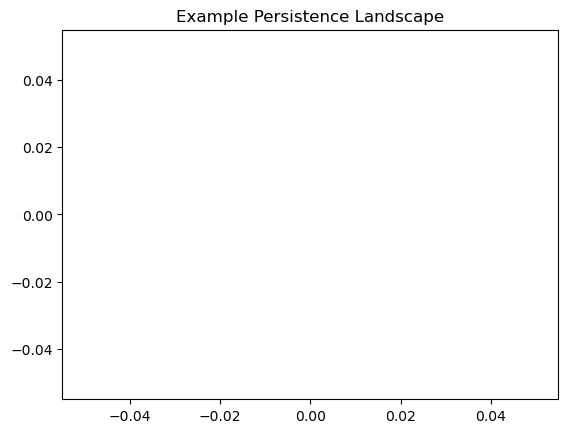

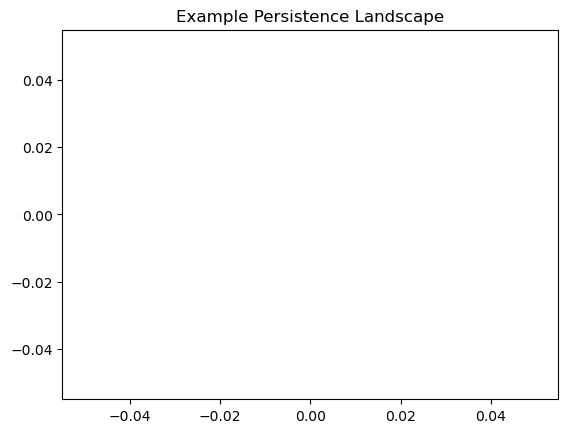

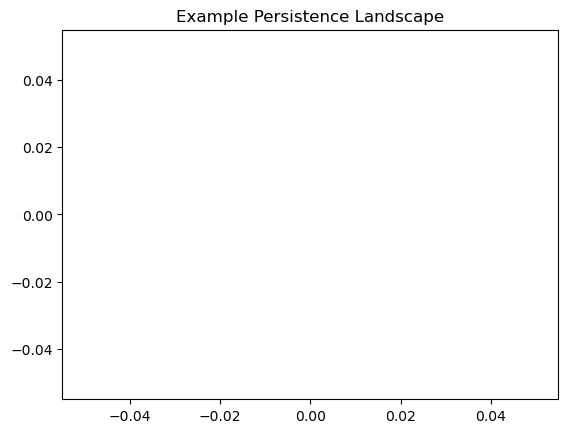

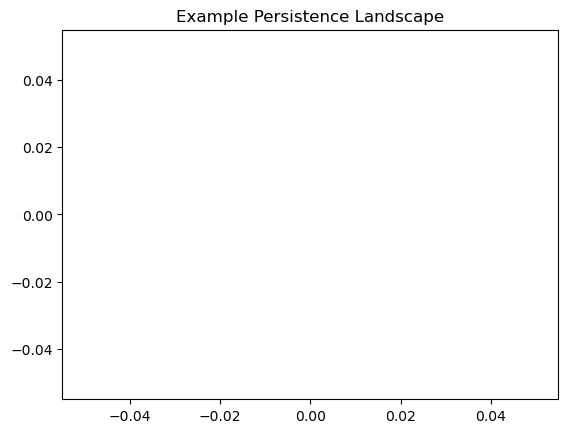

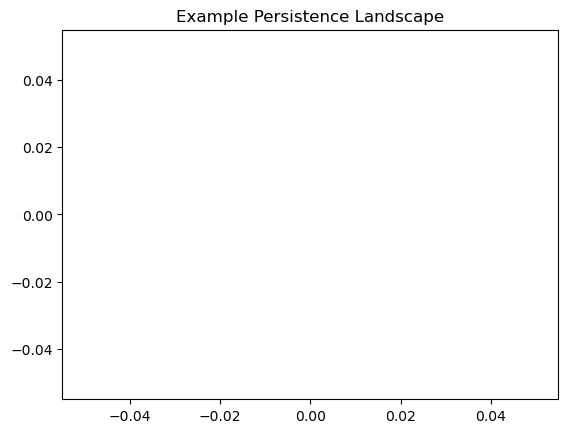

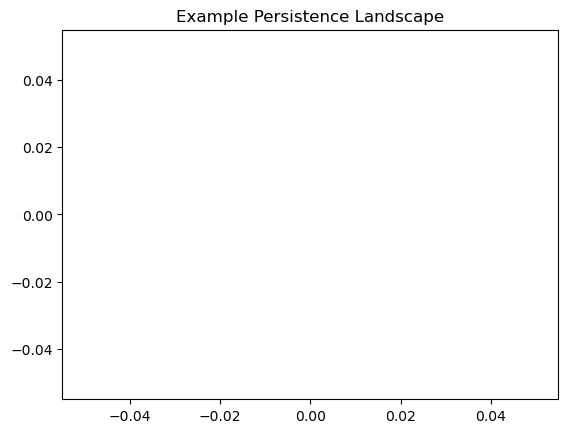

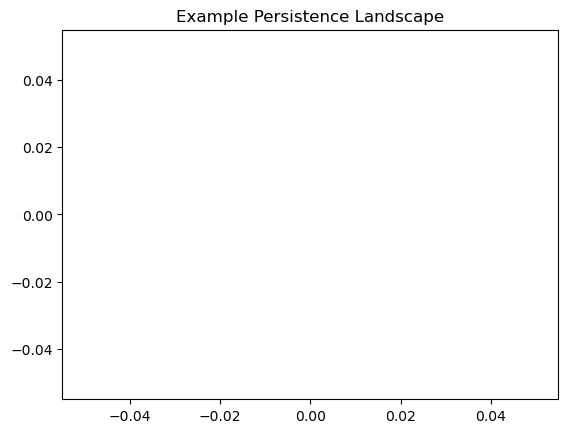

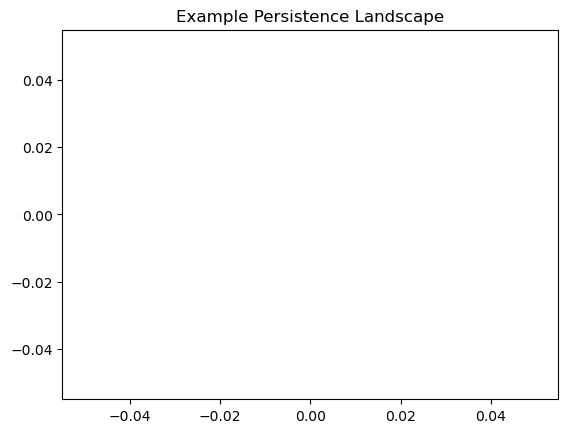

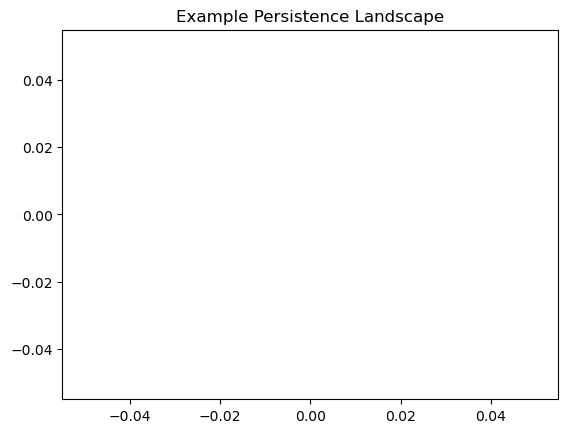

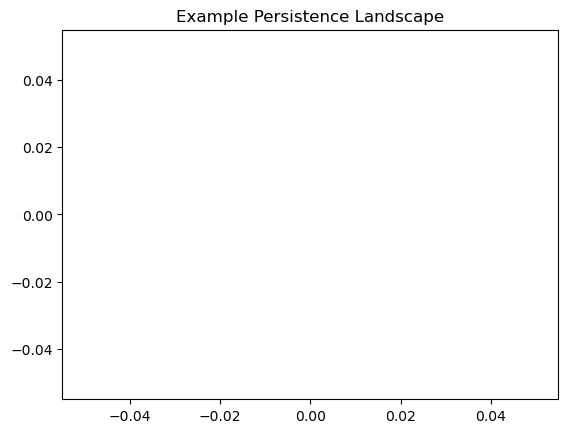

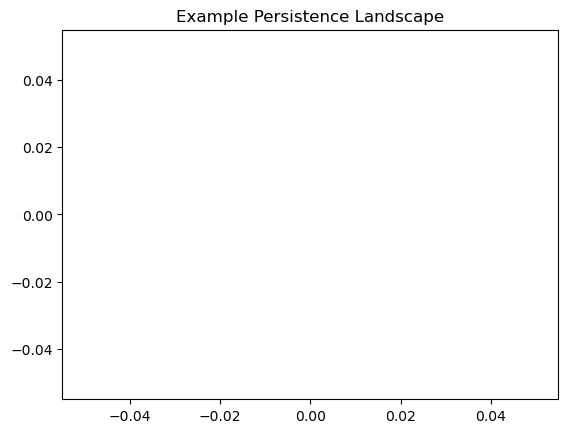

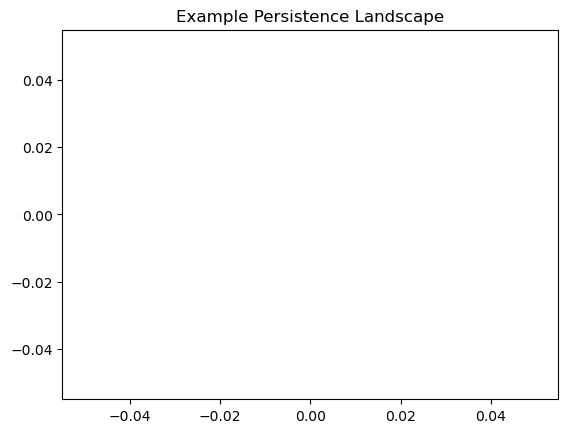

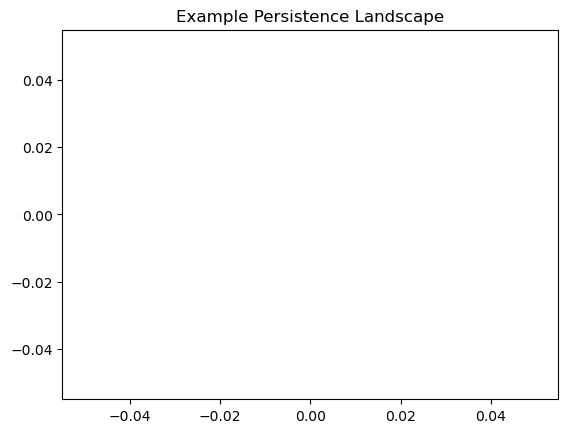

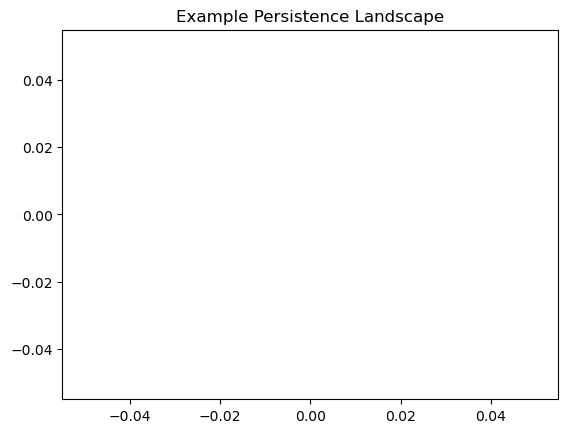

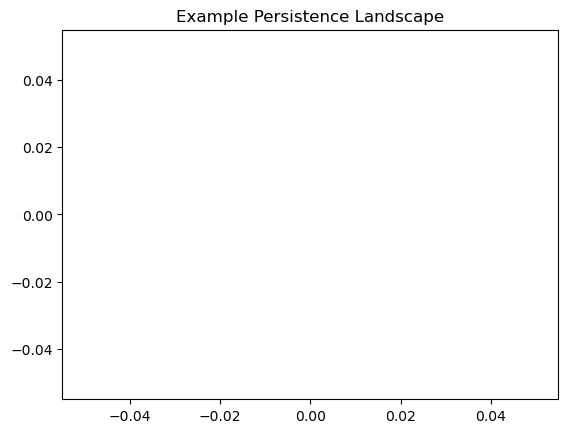

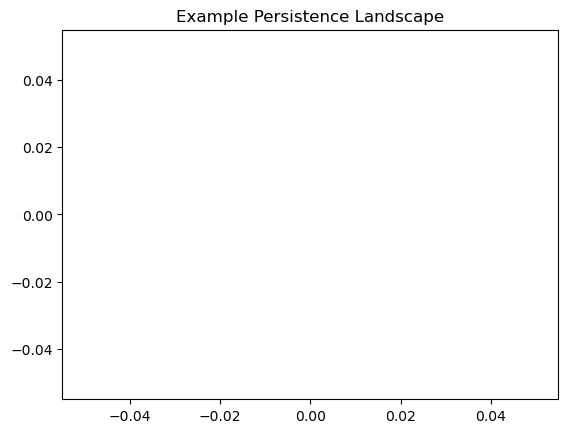

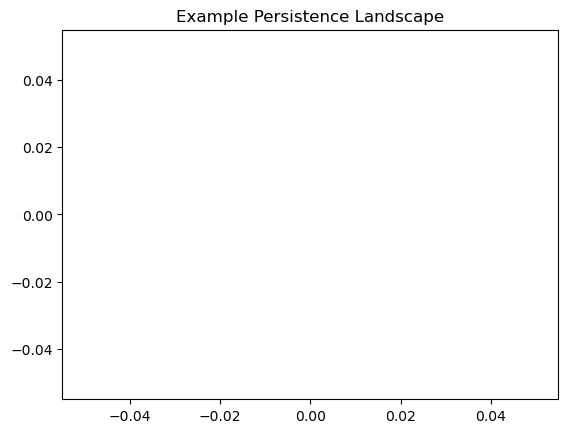

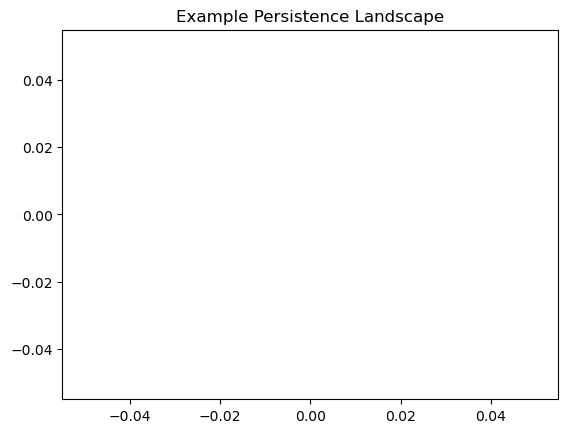

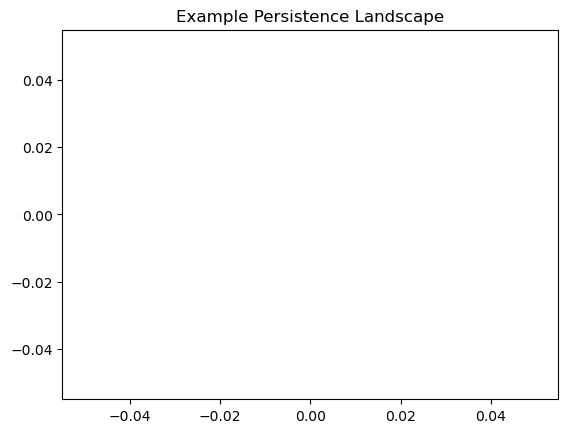

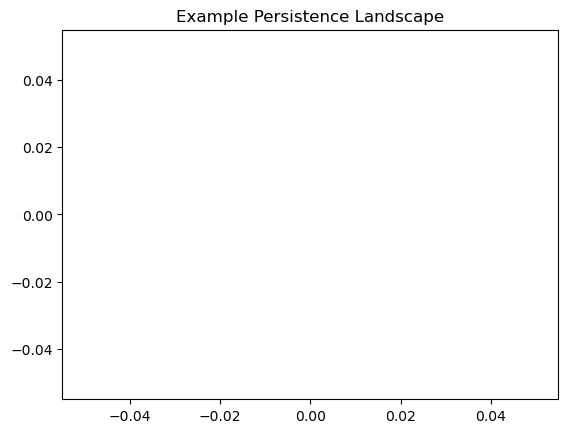

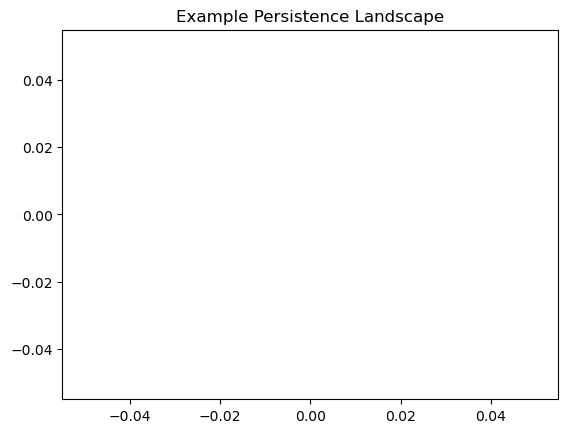

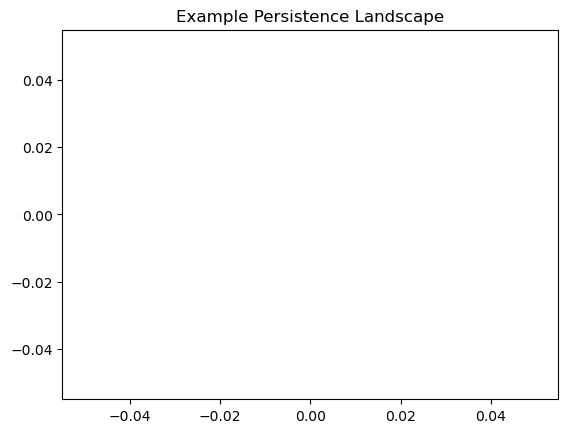

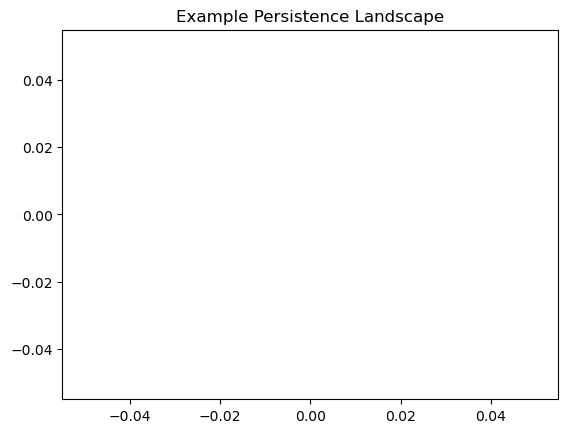

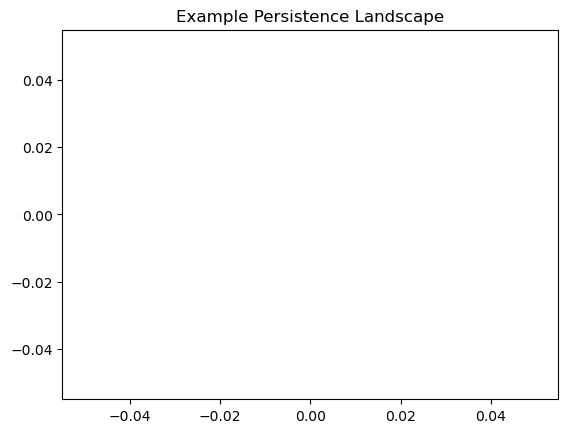

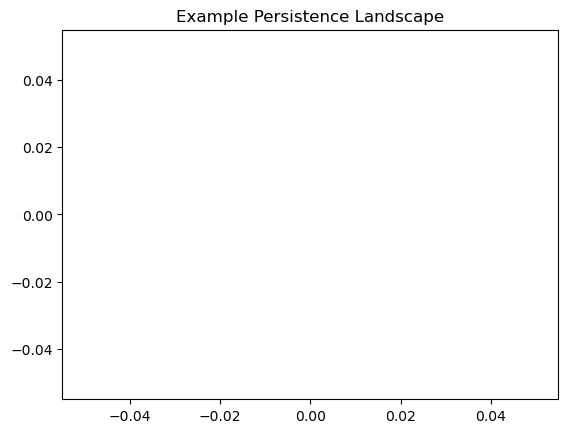

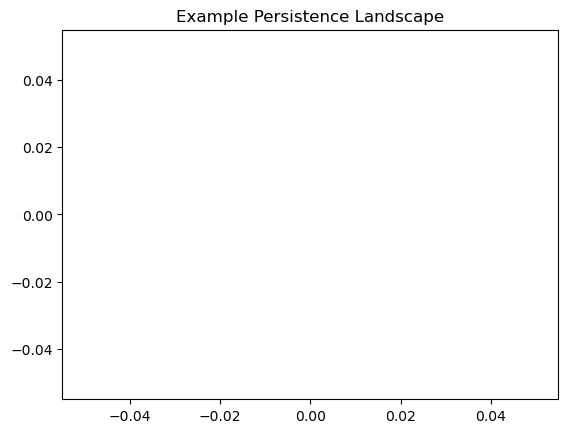

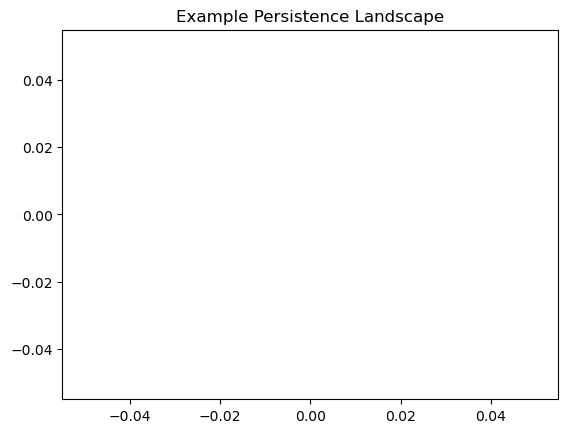

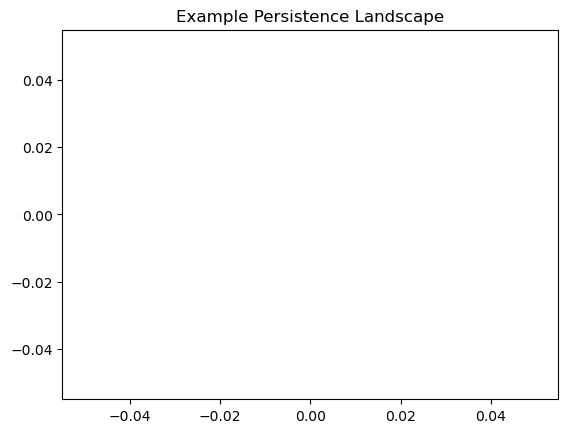

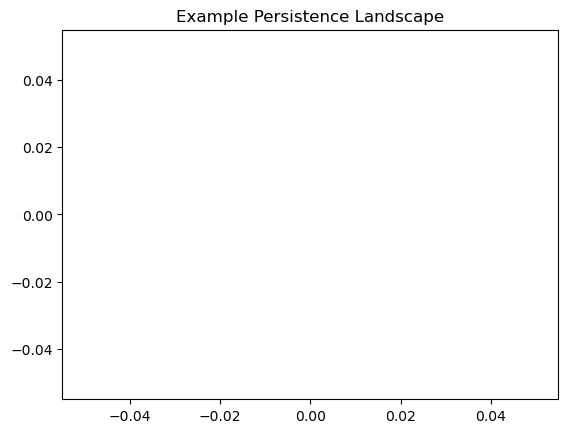

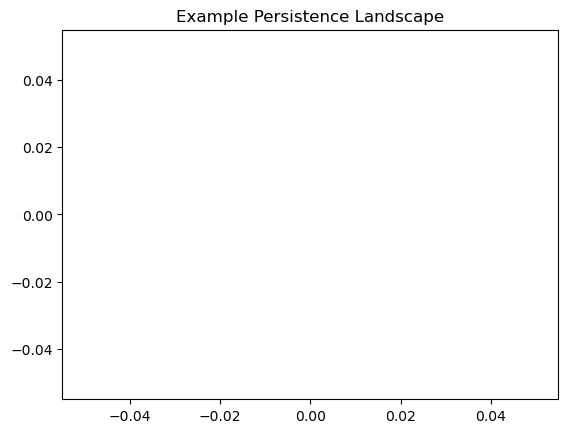

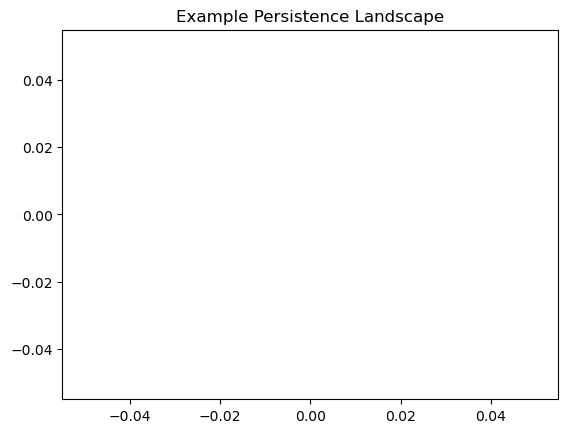

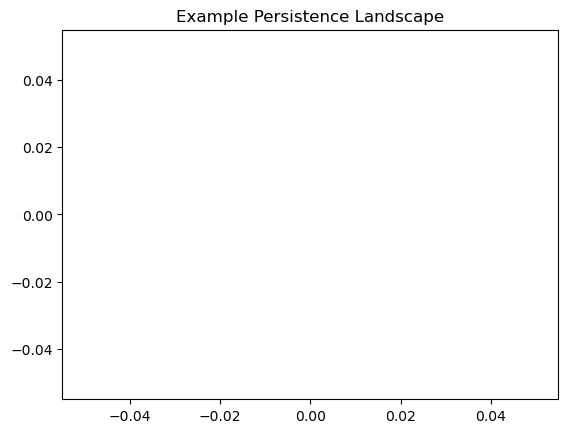

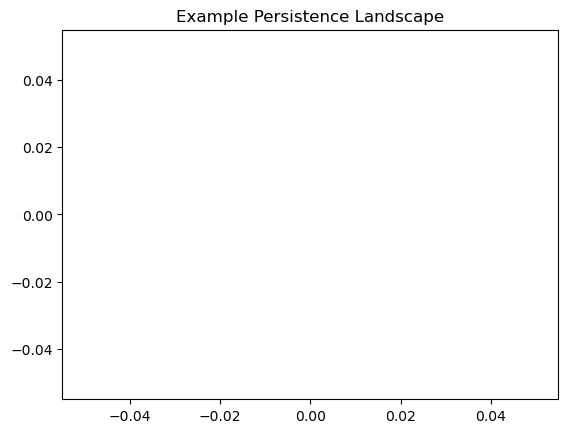

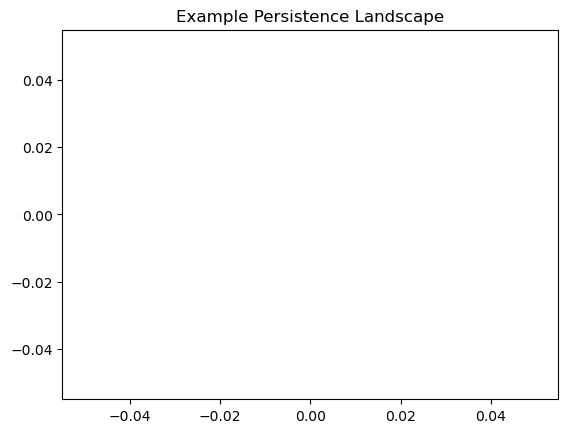

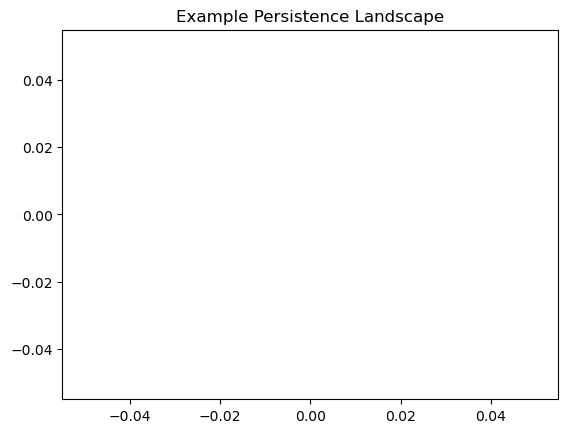

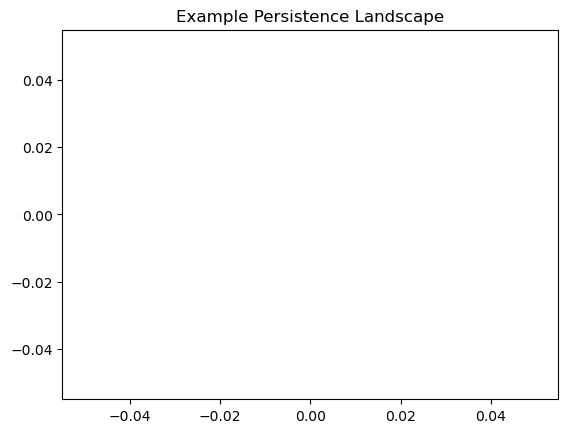

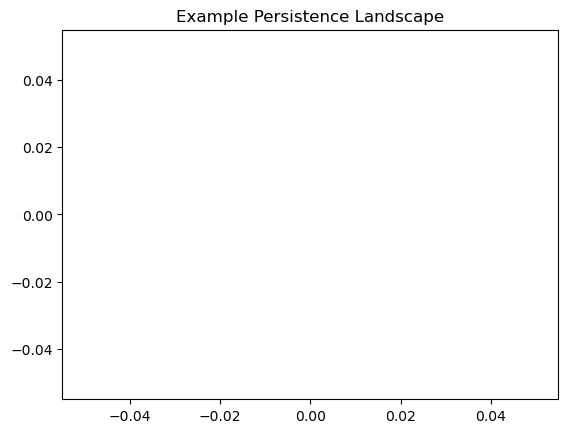

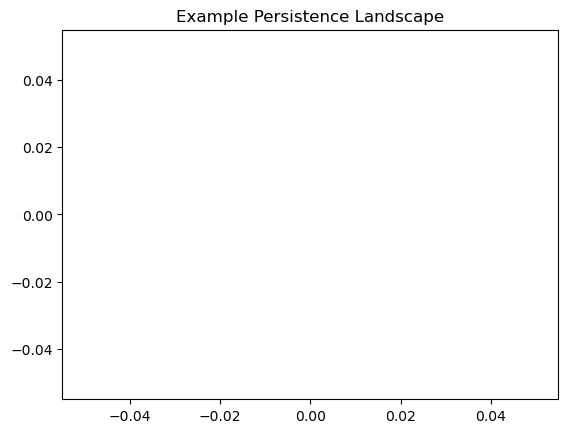

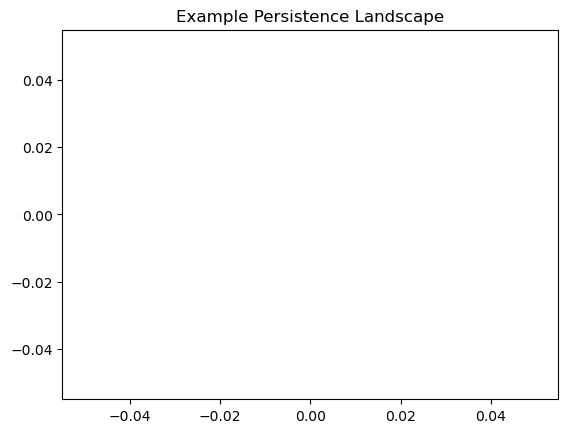

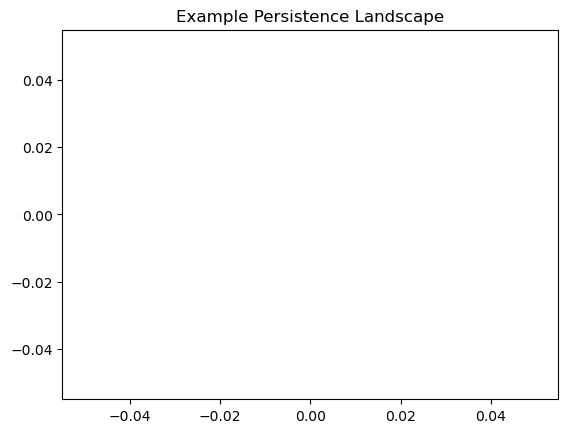

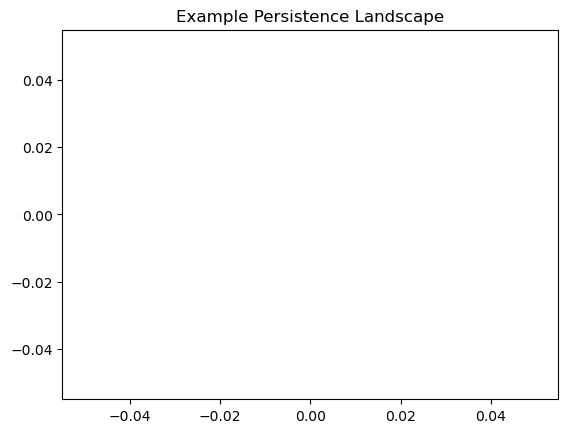

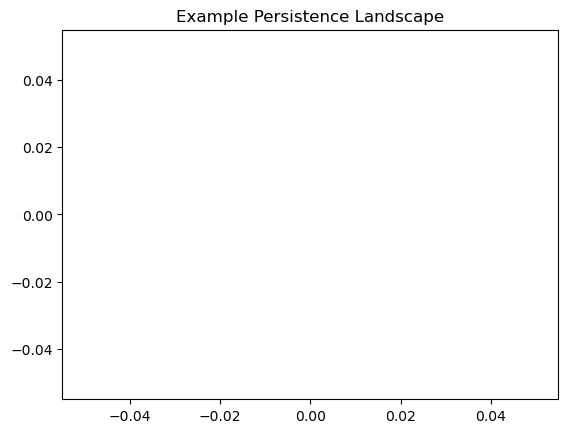

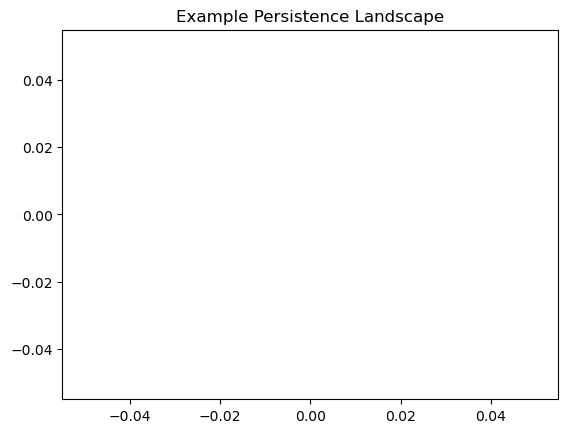

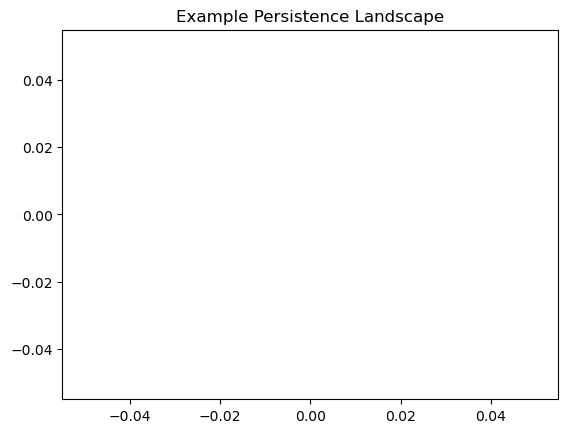

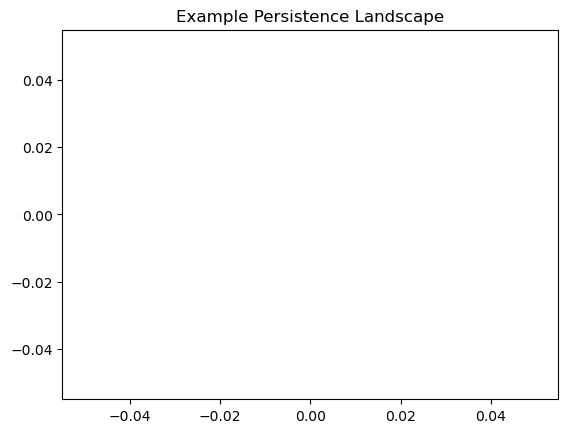

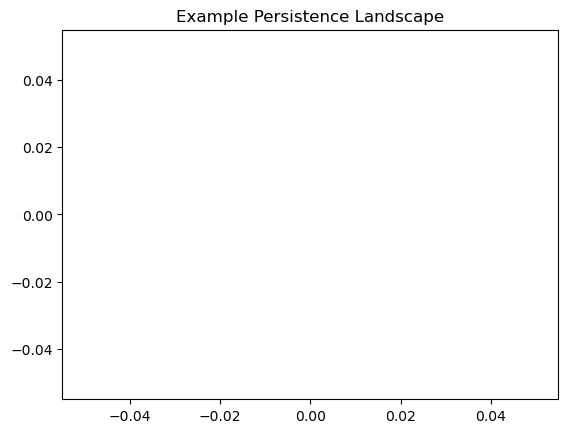

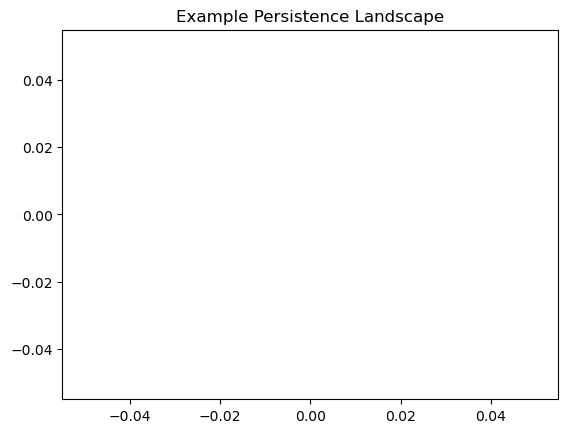

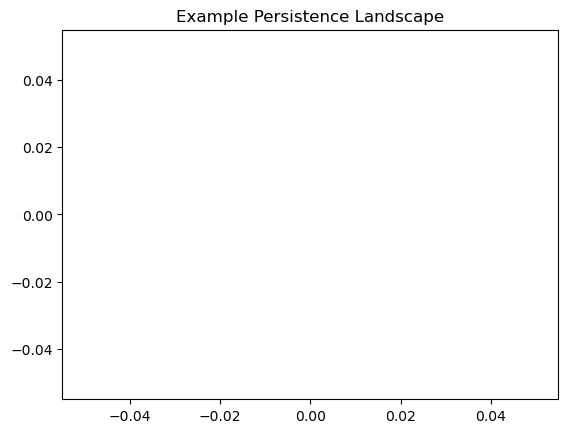

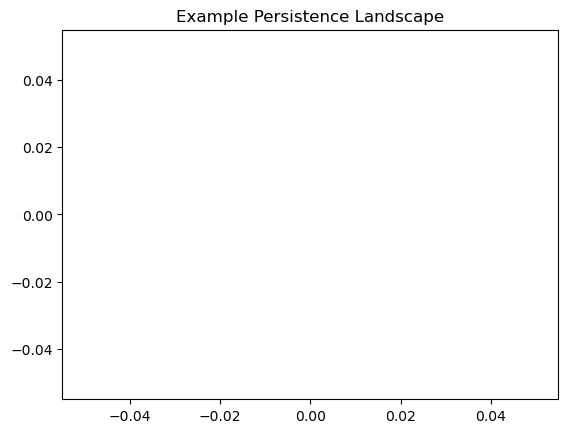

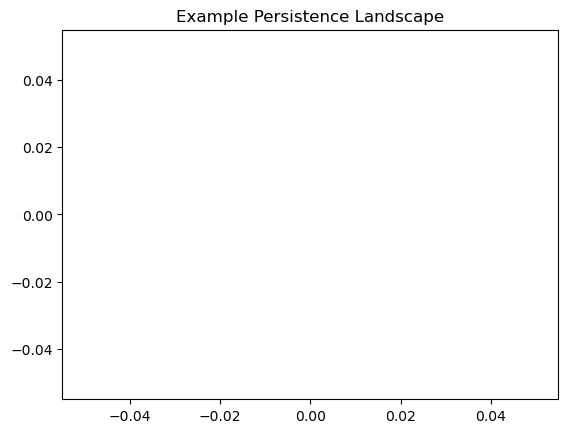

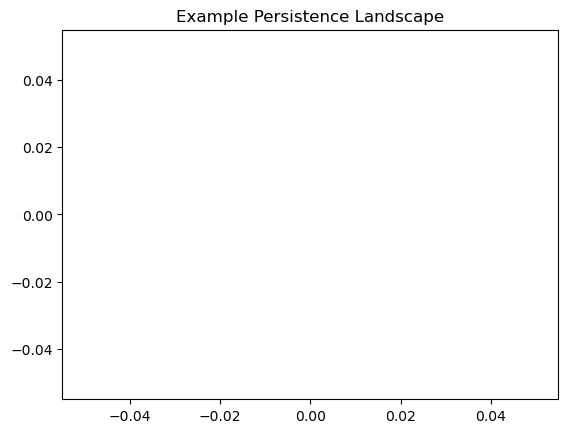

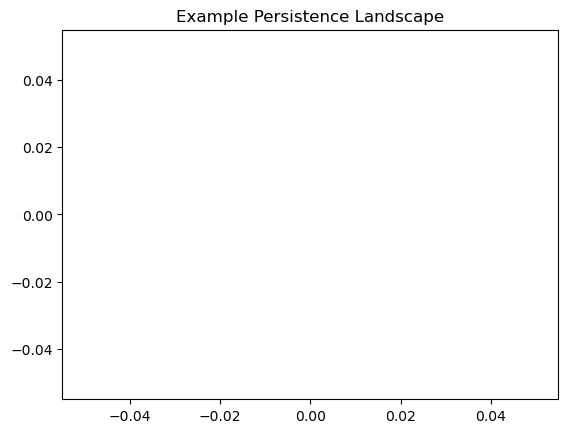

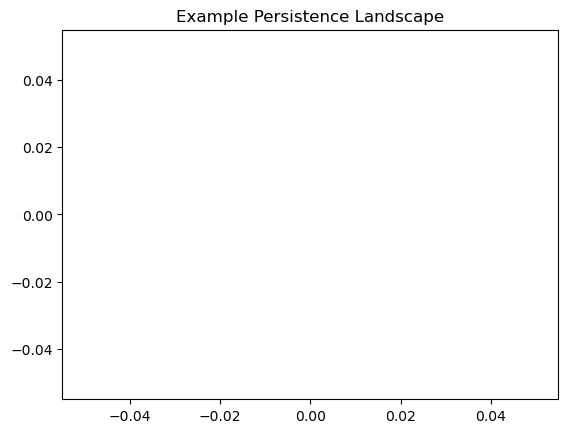

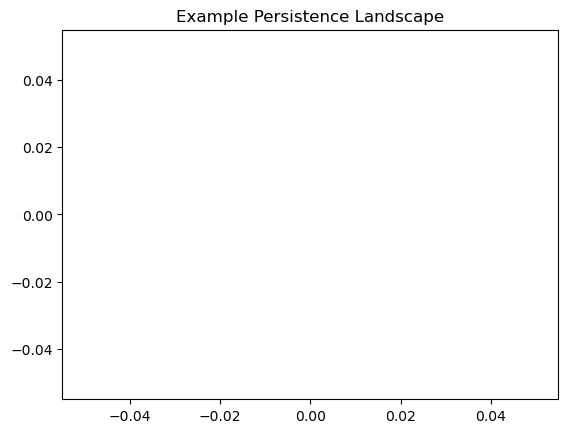

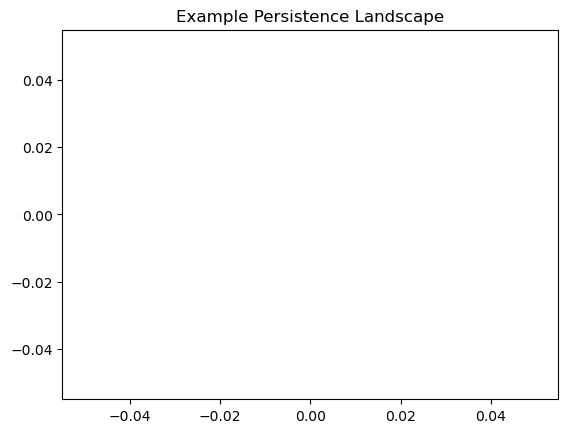

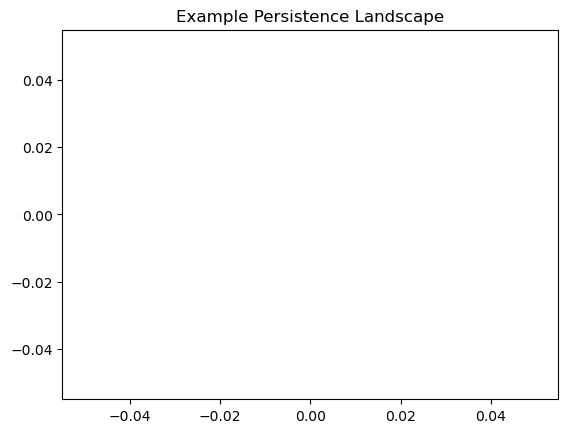

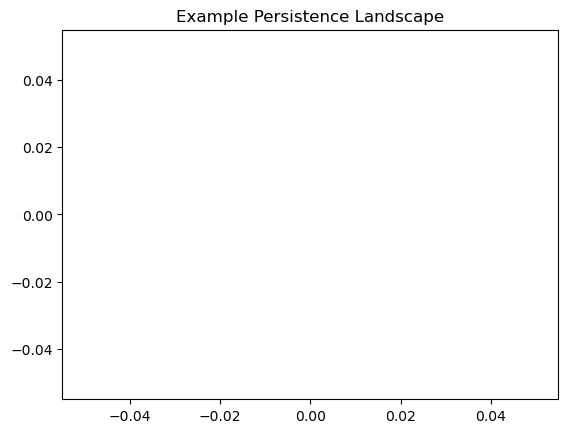

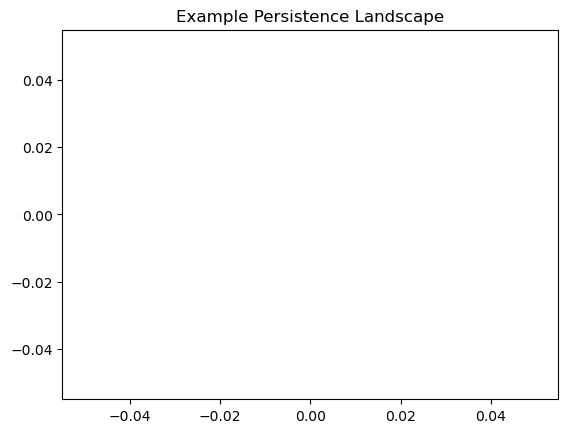

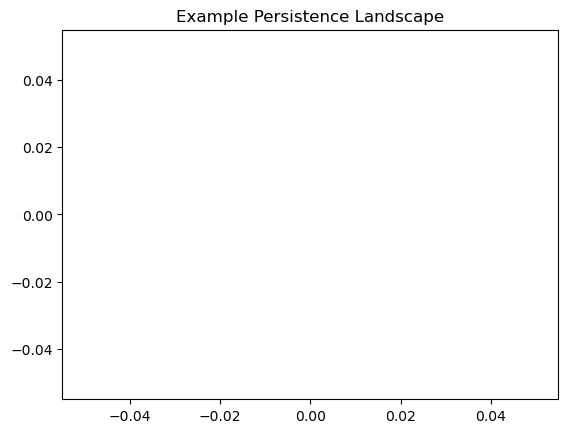

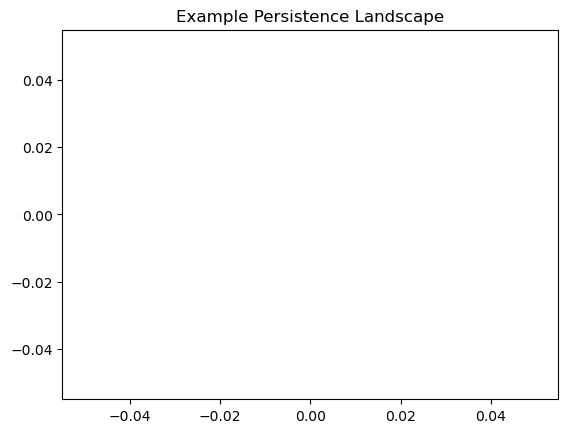

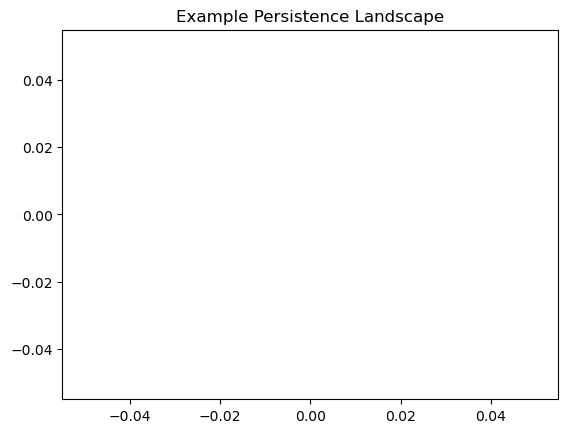

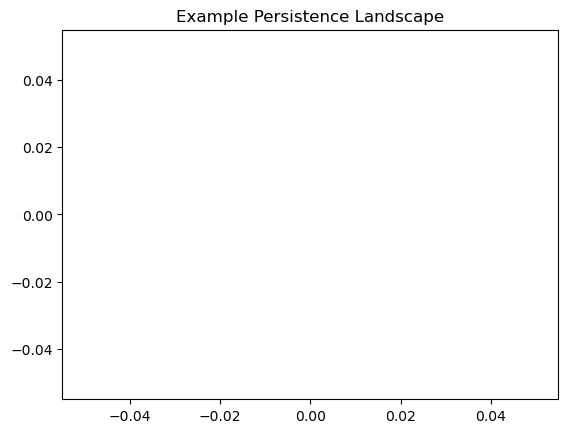

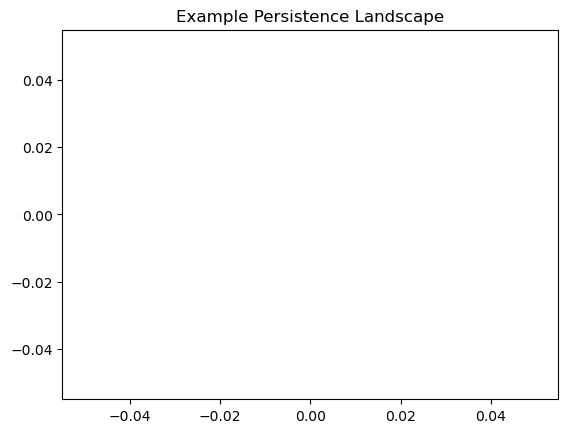

In [24]:
plt.figure(figsize=(12, 5))
for i in range(len(landscapes)):
    plt.plot(diagrams[i])
    plt.title("Example Persistence Landscape"); plt.show()